In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import aim
from aim.pytorch import track_gradients_dists, track_params_dists
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

print_config()

--------------------------------------------------------------------------
                 Aim collects anonymous usage analytics.                 
                        Read how to opt-out here:                         
    https://aimstack.readthedocs.io/en/latest/community/telemetry.html    
--------------------------------------------------------------------------


MONAI version: 1.3.0
Numpy version: 1.26.2
Pytorch version: 2.1.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /<username>/miniconda3/envs/cv/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 10.1.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.7.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSIO

In [3]:
data_dir = "data/Task09_Spleen"
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [4]:
set_determinism(seed=0)

In [5]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

/root/miniconda3/envs/cv/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


image shape: torch.Size([228, 158, 113]), label shape: torch.Size([228, 158, 113])


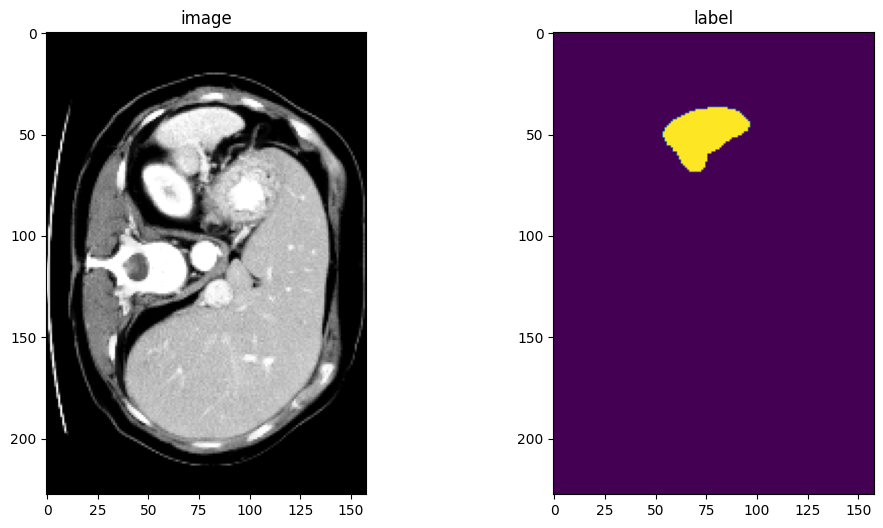

In [6]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

In [7]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
# train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 9/9 [00:05<00:00,  1.50it/s]


In [8]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")

UNet_meatdata = {
    "spatial_dims": 3,
    "in_channels": 1,
    "out_channels": 2,
    "channels": (16, 32, 64, 128, 256),
    "strides": (2, 2, 2, 2),
    "num_res_units": 2,
    "norm": Norm.BATCH,
}

model = UNet(**UNet_meatdata).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
loss_type = "DiceLoss"
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

Optimizer_metadata = {}
for ind, param_group in enumerate(optimizer.param_groups):
    optim_meta_keys = list(param_group.keys())
    Optimizer_metadata[f"param_group_{ind}"] = {
        key: value for (key, value) in param_group.items() if "params" not in key
    }

In [10]:
max_epochs = 600
val_interval = 10
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

# initialize a new Aim Run
aim_run = aim.Run()
# log model metadata
aim_run["UNet_meatdata"] = UNet_meatdata
# log optimizer metadata
aim_run["Optimizer_metadata"] = Optimizer_metadata

slice_to_track = 80

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        # track batch loss metric
        aim_run.track(loss.item(), name="batch_loss", context={"type": loss_type})

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)

    # track epoch loss metric
    aim_run.track(epoch_loss, name="epoch_loss", context={"type": loss_type})

    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        if (epoch + 1) % val_interval * 2 == 0:
            # track model params and gradients
            track_params_dists(model, aim_run)
            # THIS SEGMENT TAKES RELATIVELY LONG (Advise Against it)
            track_gradients_dists(model, aim_run)

        model.eval()
        with torch.no_grad():
            for index, val_data in enumerate(val_loader):
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)

                # tracking input, label and output images with Aim
                output = torch.argmax(val_outputs, dim=1)[0, :, :, slice_to_track].float()

                aim_run.track(
                    aim.Image(val_inputs[0, 0, :, :, slice_to_track], caption=f"Input Image: {index}"),
                    name="validation",
                    context={"type": "input"},
                )
                aim_run.track(
                    aim.Image(val_labels[0, 0, :, :, slice_to_track], caption=f"Label Image: {index}"),
                    name="validation",
                    context={"type": "label"},
                )
                aim_run.track(
                    aim.Image(output, caption=f"Predicted Label: {index}"),
                    name="predictions",
                    context={"type": "labels"},
                )

                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # track val metric
            aim_run.track(metric, name="val_metric", context={"type": loss_type})

            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join("model", "best_metric_model.pth"))

                best_model_log_message = f"saved new best metric model at the {epoch+1}th epoch"
                aim_run.track(aim.Text(best_model_log_message), name="best_model_log_message", epoch=epoch + 1)
                print(best_model_log_message)

            message1 = f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
            message2 = f"\nbest mean dice: {best_metric:.4f} "
            message3 = f"at epoch: {best_metric_epoch}"

            aim_run.track(aim.Text(message1 + "\n" + message2 + message3), name="epoch_summary", epoch=epoch + 1)
            print(message1, message2, message3)

----------
epoch 1/600
1/16, train_loss: 0.5343
2/16, train_loss: 0.5557
3/16, train_loss: 0.5786
4/16, train_loss: 0.5765
5/16, train_loss: 0.4921
6/16, train_loss: 0.5367
7/16, train_loss: 0.5267
8/16, train_loss: 0.5702
9/16, train_loss: 0.5701
10/16, train_loss: 0.5092
11/16, train_loss: 0.4743
12/16, train_loss: 0.5516
13/16, train_loss: 0.5040
14/16, train_loss: 0.4884
15/16, train_loss: 0.5121
16/16, train_loss: 0.5131
epoch 1 average loss: 0.5309
----------
epoch 2/600
1/16, train_loss: 0.5580
2/16, train_loss: 0.5008
3/16, train_loss: 0.5511
4/16, train_loss: 0.5161
5/16, train_loss: 0.4843
6/16, train_loss: 0.5857
7/16, train_loss: 0.5502
8/16, train_loss: 0.5545
9/16, train_loss: 0.5370
10/16, train_loss: 0.5529
11/16, train_loss: 0.5064
12/16, train_loss: 0.5445
13/16, train_loss: 0.5120
14/16, train_loss: 0.5391
15/16, train_loss: 0.5561
16/16, train_loss: 0.5583
epoch 2 average loss: 0.5379
----------
epoch 3/600
1/16, train_loss: 0.5293
2/16, train_loss: 0.5436
3/16, tra